In [1]:
!pip install -e ../dynadojo
!pip install reservoirpy

  Cloning https://github.com/DynaDojo/dynadojo to /tmp/pip-req-build-95jwxbx3
  Running command git clone --filter=blob:none --quiet https://github.com/DynaDojo/dynadojo /tmp/pip-req-build-95jwxbx3
  Resolved https://github.com/DynaDojo/dynadojo to commit a330ccb8e2a8f2b6481bf0aeac047ace3301bbc6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-ma

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
from dynadojo.systems.lorenz import LorenzSystem
from dynadojo.systems.lv import PreyPredatorSystem
from dynadojo.systems.lds import LDSystem
from dynadojo.systems.kuramoto import KuramotoSystem

from dynadojo.wrappers import SystemChecker, AlgorithmChecker
from dynadojo.utils.lds import plot
from dynadojo.utils.lv import plot as plot_lv

: 

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

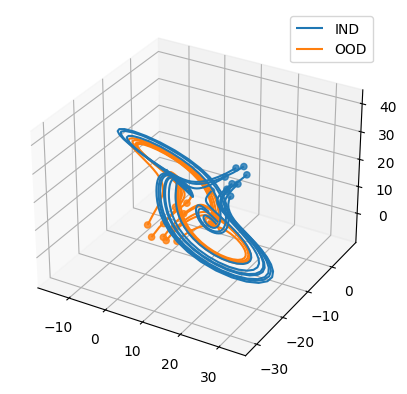

In [4]:
latent_dim = 3
embed_dim = latent_dim
n = 30
test_size = 10
timesteps = 100
system = SystemChecker(LorenzSystem(latent_dim, embed_dim, noise_scale=0, seed=1912,
                                    sigma=10, r=28, a_squared=1/2.0, b=8.0/3.0, t_range=(0, 1),))
# system = SystemChecker(LDSystem(latent_dim, embed_dim, noise_scale=0, seed=1912))
# system = SystemChecker(PreyPredatorSystem(latent_dim, embed_dim))
# system = SystemChecker(KuramotoSystem(embed_dim, embed_dim))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(n, in_dist=False)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps, noisy=False)
plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

(<Figure size 1600x400 with 3 Axes>, <Axes3D: >)

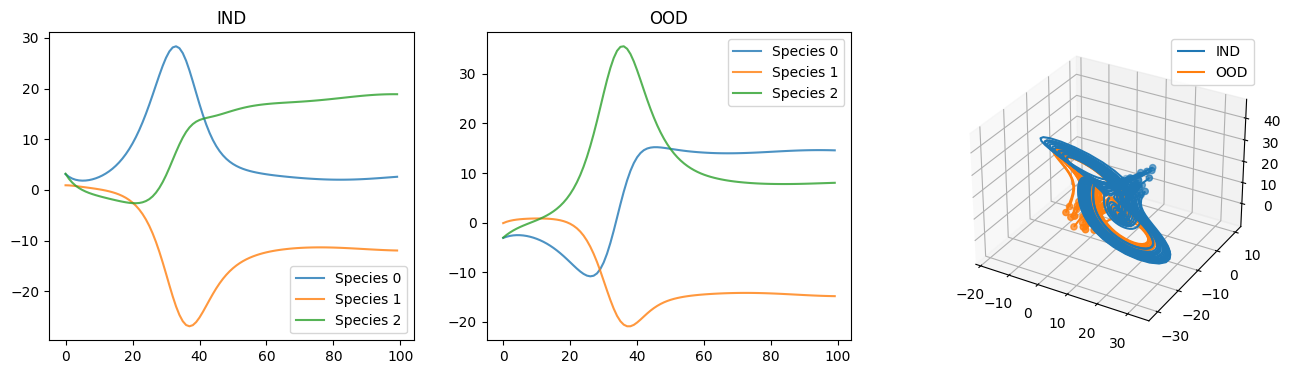

In [5]:
plot_lv([x,y],target_dim=3, labels=["IND", "OOD"], max_lines=50)

In [6]:
import numpy as np
import reservoirpy as rpy

from dynadojo.abstractions import AbstractAlgorithm

class RCBaseClass(AbstractAlgorithm):
    def __init__(self,
                 embed_dim,
                 timesteps,
                 max_control_cost,
                 seed=None,
                 config=None):
        super().__init__(embed_dim, timesteps, max_control_cost, seed)

        rpy.verbosity(config.get("verbose", 0))
        rpy.set_seed(seed)
        self.res_node = rpy.nodes.Reservoir(config.get("units", 100))
        self.readout = rpy.nodes.Ridge(embed_dim, ridge = config.get("ridge", 1e-2))
        self.model = rpy.nodes.ESN(reservoir=self.res_node, readout=self.readout, workers=config.get("workers", 1))

    def fit(self, x: np.ndarray, **kwargs):
        X_train  = x[:, :self.timesteps-1, :]
        y_train = x[:, 1:self.timesteps, :] - x[:, :self.timesteps-1, :]
        warmup = min(100, int(0.1 * X_train.shape[1]))

        self.model.fit(X_train, y_train, warmup=warmup)
        return self

    def predict(self, x0, timesteps, init_seq=None):
        if init_seq is None:
            init_seq = x0.reshape(-1,1,self.embed_dim)

        seq_len = init_seq.shape[1]
        traj = np.zeros((x0.shape[0],timesteps, self.embed_dim))
        traj[:,0:seq_len,:] = init_seq

        for ic in range(x0.shape[0]):
            self.res_node.run(init_seq[ic,seq_len-2:seq_len,:])
            u = init_seq[ic,seq_len-1,:]
            for t in range(seq_len,timesteps):
                u = u + self.model(u)
                traj[ic,t,:] = u

        return traj


In [14]:
class NVAR(RCBaseClass):
    def __init__(self,
                 embed_dim,
                 timesteps,
                 max_control_cost,
                 seed=None,
                 config=None):
        super().__init__(embed_dim, timesteps, max_control_cost, seed, config=config)
        self.verbose = config.get("verbose", 0)
        self.delay = config.get("delay", 2)
        self.order = config.get("order", 2)
        self.strides = config.get("strides", 1)
        self.ridge = config.get("ridge", 1e-2)
        self.workers = config.get("workers", 1)

        self.res_node = rpy.nodes.NVAR(delay = self.delay, order = self.order, strides = self.strides)
        self.readout = rpy.nodes.Ridge(embed_dim, ridge = self.ridge)
        self.model = rpy.nodes.ESN(reservoir=self.res_node, readout=self.readout, workers=self.workers)

In [18]:
class ESN(RCBaseClass):
    def __init__(self,
                 embed_dim,
                 timesteps,
                 max_control_cost,
                 seed=None,
                 config=None):
        super().__init__(embed_dim, timesteps, max_control_cost, seed, config=config)
        self.verbose = config.get("verbose", 0)
        self.units = config.get("units", 500)
        self.spectral_radius = config.get("spectral_radius", 0.99)
        self.leak_rate = config.get("leak_rate", 0.3)
        self.input_scaling = config.get("input_scaling", 1.0)
        self.rc_connectivity = config.get("rc_connectivity", 0.1)
        self.input_connectivity = config.get("input_connectivity", 0.2)
        self.ridge = config.get("ridge", 1e-2)
        self.workers = config.get("workers", 1)
        self.reservoir = rpy.nodes.Reservoir(self.units, input_scaling=self.input_scaling,
                                             sr=self.spectral_radius,
                                             lr=self.leak_rate,
                                             rc_connectivity=self.rc_connectivity,
                                             input_connectivity=self.input_connectivity,
                                             seed=seed)
        self.readout = rpy.nodes.Ridge(embed_dim, ridge = self.ridge)
        self.model = rpy.nodes.ESN(reservoir=self.res_node, readout=self.readout, workers=self.workers)

In [36]:
nvar_config = {
    "verbose": 0,
    "delay": 2,
    "order": 2,
    "strides": 1,
    "ridge": 2.5e-2,
    "workers": 1,
}

In [37]:
model = AlgorithmChecker(NVAR(embed_dim, timesteps, max_control_cost=0, seed=109, config=nvar_config))
model.fit(x)

In [29]:
esn_config1 = {
    "verbose": 0,
    "units": 400,
    "spectral_radius": 1e-3,
    "leak_rate": 1e0,
    "rc_connectivity": 0.1,
    "input_connectivity": 0.3,
    "ridge": 9e-6
    }

In [30]:
model = AlgorithmChecker(ESN(embed_dim, timesteps, max_control_cost=0, seed=109, config=esn_config1))
model.fit(x)

In [33]:
esn_config2 = {
    "verbose": 0,
    "units": 300,
    "spectral_radius": 1e1,
    "leak_rate": 1e-2,
    "rc_connectivity": 0.1,
    "input_connectivity": 0.2,
    "ridge": 9e-4
    }

In [34]:
model = AlgorithmChecker(ESN(embed_dim, timesteps, max_control_cost=0, seed=109, config=esn_config2))
model.fit(x)

x_err=7.288130645160399


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

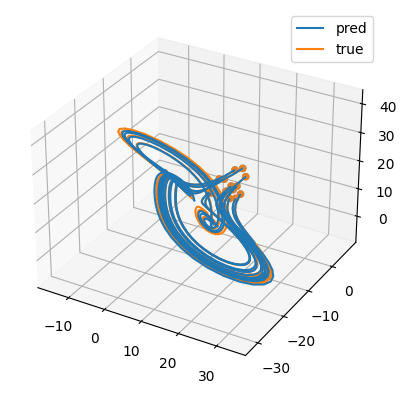

In [38]:
x_pred = model.predict(x0, timesteps, init_seq=x[:,:10,:])
x_err = system.calc_error(x, x_pred)
print(f"{x_err=}")
plot([x_pred, x], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)

(<Figure size 1600x400 with 3 Axes>, <Axes3D: >)

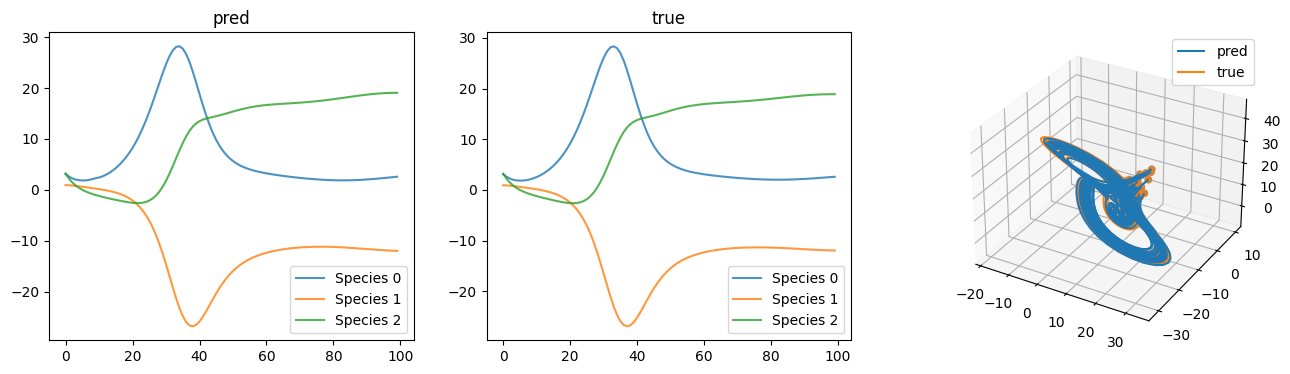

In [39]:
plot_lv([x_pred,x],target_dim=3, labels=["pred", "true"], max_lines=50)

y_err=6.738510253975511


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

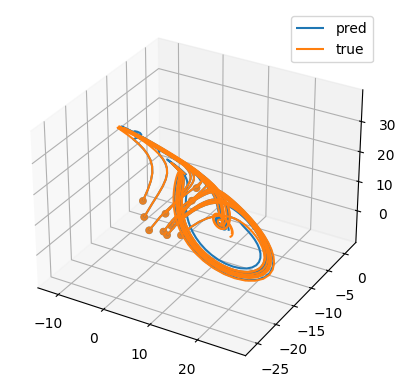

In [40]:
y_pred = model.predict(y0, timesteps, init_seq=y[:,:10,:])
y_err = system.calc_error(y, y_pred)
print(f"{y_err=}")
plot([y_pred, y], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)

(<Figure size 1600x400 with 3 Axes>, <Axes3D: >)

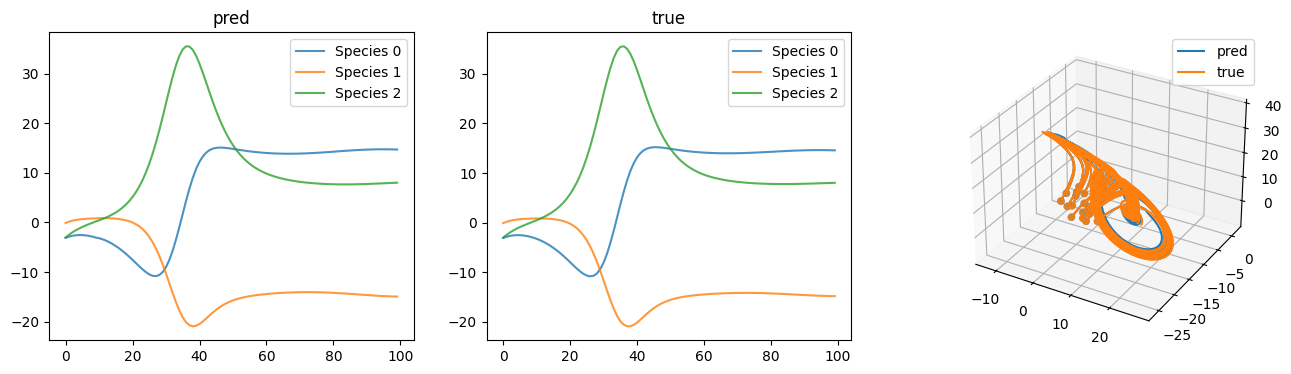

In [41]:
plot_lv([y_pred,y],target_dim=3, labels=["pred", "true"], max_lines=50)

In [42]:
!pip install ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 8.4 MB/s eta 0:00:00


In [43]:
from ray import tune

nvar_search_space = {
    "delay": tune.choice([1,2]),
    "order": tune.choice([1,2,3]),
    "ridge": tune.loguniform(1e-8, 1e1),
    "strides": 1,
    "init_seq_len": tune.randint(10,30)
}

esn_search_space = {
    "units": tune.choice([100,200,300,400,500]),
    "spectral_radius": tune.loguniform(1e-3, 1e1),
    "leak_rate": tune.loguniform(1e-4, 1),
    "input_scaling": tune.choice([1]),
    "rc_connectivity": tune.choice([0.1]),
    "input_connectivity": tune.choice([0.1, 0.2, 0.3]),
    "ridge": tune.loguniform(1e-8, 1e1),
    "init_seq_len": tune.randint(10,30)
}